In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTForMaskedImageModeling
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from vit_model import ViTForMultitask3, ViTForImageClassification2


# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [43]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# def load_data(): 
#     dataset = load_dataset("mrm8488/ImageNet1K-val")
#     dataset = dataset['train']
#     splits = dataset.train_test_split(test_size=0.1, seed=42)
#     test_ds = splits['test']
#     splits = splits['train'].train_test_split(test_size=0.1, seed=42)
#     train_ds = splits['train']
#     val_ds = splits['test']
#     return train_ds, val_ds, test_ds

# train_ds, val_ds, test_ds = load_data()

# image = train_ds[1]['image']

pretrained_name = 'google/vit-base-patch16-224'

config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)

# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier


In [71]:
from img_utils import generate_mask
n_samples = 4000

with torch.no_grad():
    mask = generate_mask(mask_size=14*14, mask_probability=0.7, batch_size=n_samples)
    mask = mask.to(device)
    mask = mask.reshape(-1, 1, 14,14)
    masked_pixels = F.interpolate(mask, inputs['pixel_values'].shape[-2:], mode='nearest')
    x = inputs['pixel_values'].expand(n_samples, -1, -1, -1)
    x_masked = x * (1 - masked_pixels)

    outputs = pred_model(pixel_values=x_masked)

In [88]:
from utils import idx_to_selector
predicted_class_idx_expanded = (torch.ones(n_samples) * predicted_class_idx).long().to(device)
probs = torch.softmax(outputs.logits, dim=-1)
selector = idx_to_selector(predicted_class_idx_expanded, 1000)

probs = (probs * selector) * (outputs.logits.argmax(-1) == predicted_class_idx).unsqueeze(-1)
probs = probs.sum(-1)

In [90]:
(outputs.logits.argmax(-1) == predicted_class_idx).sum().item()

140

In [95]:
weighted_mask = (probs.reshape(-1, 1, 1, 1) * (1 - mask)).sum(0).squeeze(0).cpu().detach().numpy()

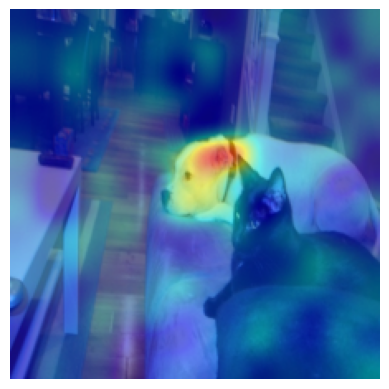

In [96]:
from utils.img_utils import plot_overlap_np, unnormalize
img = x[0].cpu().detach().numpy().transpose(1,2,0)
heatmap = weighted_mask
_, _ = plot_overlap_np(img, heatmap, mean, std)

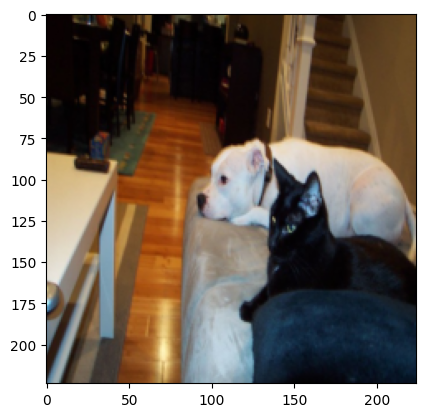

In [65]:
plt.imshow(unnormalize(img, mean, std))

In [53]:
heatmap

array([[25.053082, 25.065544, 25.09193 , 24.77479 , 26.87725 , 25.567616,
        27.329311, 21.306715, 26.781517, 27.755291, 25.301872, 26.961819,
        25.65448 , 27.368584],
       [25.377794, 27.395721, 27.674458, 25.323864, 28.144836, 26.717583,
        27.973572, 25.73487 , 24.175997, 26.679337, 24.354412, 25.263435,
        26.890526, 25.331352],
       [22.633854, 27.242489, 24.274628, 25.151842, 27.80909 , 27.962505,
        25.984325, 24.428612, 27.774654, 25.410854, 26.780409, 26.317513,
        26.480787, 27.924086],
       [24.937927, 23.815458, 23.098957, 27.038624, 26.248022, 24.395845,
        23.120453, 25.824358, 26.203547, 26.990843, 25.237682, 25.574339,
        27.724495, 26.090895],
       [26.286224, 28.362297, 27.1221  , 26.760708, 26.142372, 26.559069,
        21.124203, 24.799122, 24.543537, 27.75628 , 26.194399, 23.346054,
        25.39319 , 26.538786],
       [28.637663, 27.853954, 25.51294 , 23.865398, 22.958435, 29.6211  ,
        36.986004, 39.38366 , 3